In [6]:
## import libraries
import os, sys
import yaml
import re
import xarray as xr
import pandas as pd
import numpy as np
from datetime import timedelta
%matplotlib inline
from datetime import timedelta

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import textwrap

# import personal modules
sys.path.append('../modules')
import custom_cmaps as ccmap
from plotter import draw_basemap
# dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [30]:
def compare_mclimate_to_forecast(fc, mclimate, varname):
    ## compare forecast to mclimate
    if varname == 'ivt':
        var1 = 'ivt'
        var2 = 'IVT'
    elif varname == 'uv1000':
        var1 = 'uv'
        var2 = 'uv'
    b_lst = []
    quant_lst = [0.  , 0.75, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]
    nquantiles = len(quant_lst)
    for i, quant in enumerate(range(nquantiles)):
        bottom = mclimate[var1].isel(quantile=quant).squeeze() # minimum threshold
        
        if i == 0:
            # only need to see where IVT in the forecast is less than minimum quantile
            b = xr.where(cond=fc[var2] < bottom, x=quant_lst[i], y=np.nan)
            
        elif (i > 0) & (i < nquantiles-1):
            # where IVT in the forecast is greater than current quartile, but less than next quartile
            top = mclimate[var1].isel(quantile=i+1)
            b = xr.where(cond=(fc[var2] > bottom) & (fc[var2] < top), x=quant_lst[i], y=np.nan)
            
        elif (i == nquantiles-1):
            # where IVT is greater than final quartile
            b = xr.where(cond=(fc[var2] > bottom), x=quant_lst[i], y=np.nan)
    
        b.name = 'ivt'
        
        var_dict = {'mclimate': (['forecast_hour', 'lat', 'lon'], b.squeeze().values)}
        new_ds = xr.Dataset(var_dict,
                        coords={'lat': (['lat'], b.lat.values),
                                'lon': (['lon'], b.lon.values),
                                'forecast_hour': (['forecast_hour'], b.forecast_hour.values)})
        
        b_lst.append(new_ds)
            
    ds = xr.merge(b_lst)

    return ds

    

In [38]:
## load all lead times
## load the forecast
fname = path_to_data + 'downloads/GFS_025d/IVT_Full_2023110112.nc'
forecast = xr.open_dataset(fname)

# pull the initialization date from the filename
regex = re.compile(r'\d+')
date_string = regex.findall(fname)
date_string = date_string[3]
init_time = pd.to_datetime(date_string, format="%Y%m%d%H")

## clean the file a bit to match Mclimate
forecast = forecast.assign({"init_time": init_time})
forecast = forecast.assign_coords({"lon": (((forecast.lon + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
forecast = forecast.sel(lon=slice(-179.5, -110.)) # to match mclimate grid
forecast = forecast.drop_vars(["uIVT", "vIVT"])
forecast = forecast.sel(forecast_hour=range(6, 246, 6)) ## select every 6 hours up to 10 days lead time
forecast = forecast.mean('ensemble') # ensemble mean

valid_time = []
for i, F in enumerate(forecast.forecast_hour.values):
    valid_time.append(init_time  + timedelta(hours=int(F)))
forecast = forecast.assign_coords(valid_time=("forecast_hour", valid_time))
## pull the month and day from the forecast file to open the appropriate mclimate files
month = init_time.strftime('%m')
day = init_time.strftime('%d')

forecast


<xarray.Dataset>
Dimensions:        (forecast_hour: 40, lat: 361, lon: 140)
Coordinates:
  * forecast_hour  (forecast_hour) float32 6.0 12.0 18.0 ... 228.0 234.0 240.0
  * lat            (lat) float32 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
  * lon            (lon) float32 -179.5 -179.0 -178.5 ... -111.0 -110.5 -110.0
    valid_time     (forecast_hour) datetime64[ns] 2023-11-01T18:00:00 ... 202...
Data variables:
    IVT            (forecast_hour, lat, lon) float32 22.9 22.9 ... 18.8 18.8
    init_time      datetime64[ns] 2023-11-01T12:00:00

In [27]:
## load mclimate data
day = 11 ## small hack until I am done 
fname_pattern = path_to_data + 'preprocessed/mclimate/GEFSv12_reforecast_mclimate_ivt_{0}{1}_*hr-lead.nc'.format(month, day)
print(fname_pattern)
ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', concat_dim="step", combine='nested')
ds = ds.sortby("step") # sort by step (forecast lead)
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat', 'step': 'forecast_hour'}) # need to rename this to match GEFSv12 Reforecast
ds = ds.sel(lon=slice(-179.5, -110.), lat=slice(70., 10.))

## need to regrid to 0.5 degree to match GEFS 
regrid_lats = forecast.lat
regrid_lons = forecast.lon

ds = ds.interp(lon=regrid_lons, lat=regrid_lats)

ds

/expanse/nfs/cw3e/cwp140/preprocessed/mclimate/GEFSv12_reforecast_mclimate_ivt_1111_*hr-lead.nc


<xarray.Dataset>
Dimensions:        (dayofyear: 1, forecast_hour: 40, quantile: 13, lat: 361,
                    lon: 140)
Coordinates:
  * quantile       (quantile) float64 0.0 0.75 0.9 0.91 ... 0.97 0.98 0.99 1.0
  * forecast_hour  (forecast_hour) int64 6 12 18 24 30 ... 216 222 228 234 240
  * dayofyear      (dayofyear) int64 315
  * lon            (lon) float32 -179.5 -179.0 -178.5 ... -111.0 -110.5 -110.0
  * lat            (lat) float32 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
Data variables:
    ivt            (dayofyear, forecast_hour, quantile, lat, lon) float64 dask.array<chunksize=(1, 1, 13, 361, 140), meta=np.ndarray>

In [31]:
%%time
ds2 = compare_mclimate_to_forecast(forecast, ds, 'ivt')

CPU times: user 18.7 s, sys: 3.05 s, total: 21.8 s
Wall time: 4.76 s


In [33]:
ds2

<xarray.Dataset>
Dimensions:        (forecast_hour: 40, lat: 361, lon: 140)
Coordinates:
  * lat            (lat) float32 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
  * lon            (lon) float32 -179.5 -179.0 -178.5 ... -111.0 -110.5 -110.0
  * forecast_hour  (forecast_hour) float32 6.0 12.0 18.0 ... 228.0 234.0 240.0
Data variables:
    mclimate       (forecast_hour, lat, lon) float64 nan nan nan ... nan nan nan

In [50]:
def plot_mclimate(mclim, fc, varname, F):
    '''
    plot mclimate and forecast values
    
    Parameters
    ----------
    mclim : 3-D xarray
        xarray of mclimate values for 10 day forecast
    fc : 3-D xarray
        xarray of forecast that was compared to mclimate
    varname : string
        variable name to plot
    F : int
        forecast lead

    Returns
    -------
    x : png
    '''
    
    # Set up projection
    mapcrs = ccrs.PlateCarree()
    datacrs = ccrs.PlateCarree()
    
    # Set tick/grid locations
    lats = ds.lat.values
    lons = ds.lon.values
    
    # ext = [-170., -120., 40., 65.]
    ext = [-140., -130., 53., 63.]
    
    r = 2
    dx = np.arange(lons.min().round(),lons.max().round()+r,r)
    dy = np.arange(lats.min().round(),lats.max().round()+r,r)

    # Create figure
    fig = plt.figure(figsize=(6, 5))
    fig.dpi = 300
    fname = path_to_figs + 'mclimate_output/mclimate_forecast_{0}'.format(F)
    fmt = 'png'
    
    nrows = 1
    ncols = 2
    
    # contour labels
    kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    
    kw_ticklabels = {'size': 10, 'color': 'dimgray', 'weight': 'light'}
    
    ## Use gridspec to set up a plot with a series of subplots that is
    ## n-rows by n-columns
    gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1, 0.05], wspace=0.001, hspace=0.05)
    ## use gs[rows index, columns index] to access grids
    
    ax = fig.add_subplot(gs[0, 0], projection=mapcrs) 
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)
    
    # Contour Filled - Mclimate values
    data = mclim.mclimate.values*100.
    cmap, norm, bnds = ccmap.cmap('mclimate_purple')
    cf = ax.contourf(mclim.lon, mclim.lat, data, transform=datacrs,
                     levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither')
    
    # Contour Lines
    clevs = np.arange(250., 2100., 250.)
    cs = ax.contour(fc.lon, fc.lat, fc[varname], transform=datacrs,
                     levels=clevs, colors='k',
                     linewidths=0.75, linestyles='solid')
    plt.clabel(cs, **kw_clabels)
    
    ts = pd.to_datetime(str(fc.init_time.values)) 
    init_time = ts.strftime('%HZ %d %b %Y')
    start_date = ts - timedelta(days=45)
    start_date = start_date.strftime('%d-%b')
    end_date = ts + timedelta(days=45)
    end_date = end_date.strftime('%d-%b')
    
    ts = pd.to_datetime(str(fc.valid_time.values)) 
    valid_time = ts.strftime('%HZ %d %b %Y')
    
    ax.set_title('Model Run: {0}'.format(init_time), loc='left', fontsize=8)
    ax.set_title('Valid Date: {0}'.format(valid_time), loc='right', fontsize=8)

    
    txt = 'Relative to all {2}-h GEFSv12 reforecasts initialized between {0} and {1} (2000-2019)'.format(start_date, end_date, F)
    ann_ax = fig.add_subplot(gs[-1, 0])
    ann_ax.axis('off')
    ann_ax.annotate(textwrap.fill(txt, 60), # this is the text
               (0, 0.), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(25,-35), # distance from text to points (x,y)
                ha='left', # horizontal alignment can be left, right or center
                **kw_ticklabels)
    
    
    # Add color bar
    cbax = plt.subplot(gs[0,-1]) # colorbar axis
    cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
    cb.set_label('Model Climate Percentile Rank (xth)', fontsize=10)
    cb.ax.tick_params(labelsize=8)
    
    fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
    plt.close()

In [51]:
%%time
for i, F in enumerate(range(6, 246, 6)):
    plot_mclimate(ds2.sel(forecast_hour=F), forecast.sel(forecast_hour=F), 'IVT', F)

CPU times: user 30.6 s, sys: 21.5 s, total: 52.1 s
Wall time: 28.8 s


In [4]:
## load all lead times
mon = 11
day = 15
lead = 168
varname = 'uv1000'

## load mclimate data
fname_pattern = path_to_data + 'preprocessed/mclimate/GEFSv12_reforecast_mclimate_{2}_{0}{1}_*hr-lead.nc'.format(mon, day, varname)
print(fname_pattern)
ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', concat_dim="step", combine='nested')
ds = ds.sortby("step") # sort by step (forecast lead)
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'}) # need to rename this to match GEFSv12 Reforecast
ds = ds.sel(step=lead, lon=slice(-179.5, -110.), lat=slice(70., 10.))
ds

/expanse/nfs/cw3e/cwp140/preprocessed/mclimate/GEFSv12_reforecast_mclimate_uv1000_1115_*hr-lead.nc


<xarray.Dataset>
Dimensions:    (lat: 241, lon: 279, dayofyear: 1, quantile: 13)
Coordinates:
  * lat        (lat) float64 70.0 69.75 69.5 69.25 ... 10.75 10.5 10.25 10.0
  * lon        (lon) float64 -179.5 -179.2 -179.0 ... -110.5 -110.2 -110.0
  * quantile   (quantile) float64 0.0 0.75 0.9 0.91 0.92 ... 0.97 0.98 0.99 1.0
    step       int64 168
  * dayofyear  (dayofyear) int64 319
Data variables:
    uv         (dayofyear, quantile, lat, lon) float64 dask.array<chunksize=(1, 13, 241, 279), meta=np.ndarray>

In [5]:
## load the reforecast
## TODO write the code so that it chooses the right fname based on lead, day, month, year
fname = path_to_data + 'preprocessed/GEFSv12_reforecast/{0}/20131115_{0}_F147_F168.nc'.format(varname)
forecast = xr.open_dataset(fname)
forecast = forecast.rename({'longitude': 'lon', 'latitude': 'lat'}) # need to rename this to match GEFSv12 Reforecast
forecast = forecast.sel(lon=slice(-179.5, -110.))
uv = np.sqrt(forecast.u**2 + forecast.v**2)
forecast = forecast.assign(uv=(['number', 'step', 'lat','lon'],uv.data))
forecast = forecast.drop_vars(["u", "v"])
forecast = forecast.isel(step=-1) ### need to fix this so it selects the right time step based on input
forecast = forecast.mean('number') # ensemble mean
forecast

<xarray.Dataset>
Dimensions:        (lat: 281, lon: 279)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] 7 days
    isobaricInhPa  float64 ...
  * lat            (lat) float64 70.0 69.75 69.5 69.25 ... 0.75 0.5 0.25 0.0
    valid_time     datetime64[ns] ...
  * lon            (lon) float64 -179.5 -179.2 -179.0 ... -110.5 -110.2 -110.0
Data variables:
    uv             (lat, lon) float32 7.511 7.1 6.693 6.34 ... 7.009 7.016 7.08

In [6]:
ds1 = compare_mclimate_to_forecast(forecast, ds, varname)

In [7]:
## load all lead times
mon = 11
day = 14
lead = 162

## load mclimate data
fname_pattern = path_to_data + 'preprocessed/mclimate/GEFSv12_reforecast_mclimate_{2}_{0}{1}_*hr-lead.nc'.format(mon, day, varname)
print(fname_pattern)
ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', concat_dim="step", combine='nested')
ds = ds.sortby("step") # sort by step (forecast lead)
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'}) # need to rename this to match GEFSv12 Reforecast
ds = ds.sel(step=lead, lon=slice(-179.5, -110.), lat=slice(70., 10.))

/expanse/nfs/cw3e/cwp140/preprocessed/mclimate/GEFSv12_reforecast_mclimate_uv1000_1114_*hr-lead.nc


In [12]:
fname = '/home/dnash/DATA/downloads/GFS05d/gfs_4_20231114_0000_162.grb2'
forecast2 = xr.open_dataset(fname, engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
forecast2 = forecast2.rename({'longitude': 'lon', 'latitude': 'lat'}) # need to rename this to match GEFSv12 Reforecast
forecast2 = forecast2.assign_coords({"lon": (((forecast2.lon + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
forecast2 = forecast2.sel(isobaricInhPa=1000., lon=slice(-179.5, -110.), lat=slice(70., 10.))
forecast2 = forecast2.drop_vars(["gh", "t", "r", "q", "w", "wz", "absv", "o3mr"])
uv = np.sqrt(forecast2.u**2 + forecast2.v**2)
forecast2 = forecast2.assign(uv=(['lat','lon'],uv.data))
forecast2

skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/cfgrib/dataset.py", line 611, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  3

<xarray.Dataset>
Dimensions:        (lat: 121, lon: 140)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
    isobaricInhPa  float64 1e+03
  * lat            (lat) float64 70.0 69.5 69.0 68.5 ... 11.5 11.0 10.5 10.0
    valid_time     datetime64[ns] ...
  * lon            (lon) float64 -179.5 -179.0 -178.5 ... -111.0 -110.5 -110.0
Data variables:
    u              (lat, lon) float32 -2.887 -1.957 -1.767 ... -3.677 -3.427
    v              (lat, lon) float32 7.849 8.889 10.33 ... -1.891 1.319 3.289
    uv             (lat, lon) float32 8.363 9.102 10.48 ... 2.508 3.906 4.75
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-01-17T11:23 GRIB to CDM+CF via cfgrib-0.9.1...

In [14]:


ds2 = compare_mclimate_to_forecast(forecast2, ds, varname)

ds_lst = [forecast, forecast2]
fc_lst = [ds1, ds2]

In [17]:
forecast2.uv.min()

<xarray.DataArray 'uv' ()>
array(0.03399691, dtype=float32)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
    isobaricInhPa  float64 1e+03
    valid_time     datetime64[ns] ...

In [21]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = forecast.lat.values
lons = forecast.lon.values

# ext = [-170., -120., 40., 65.]
ext = [-140., -130., 53., 63.]

r = 2
dx = np.arange(lons.min().round(),lons.max().round()+r,r)
dy = np.arange(lats.min().round(),lats.max().round()+r,r)

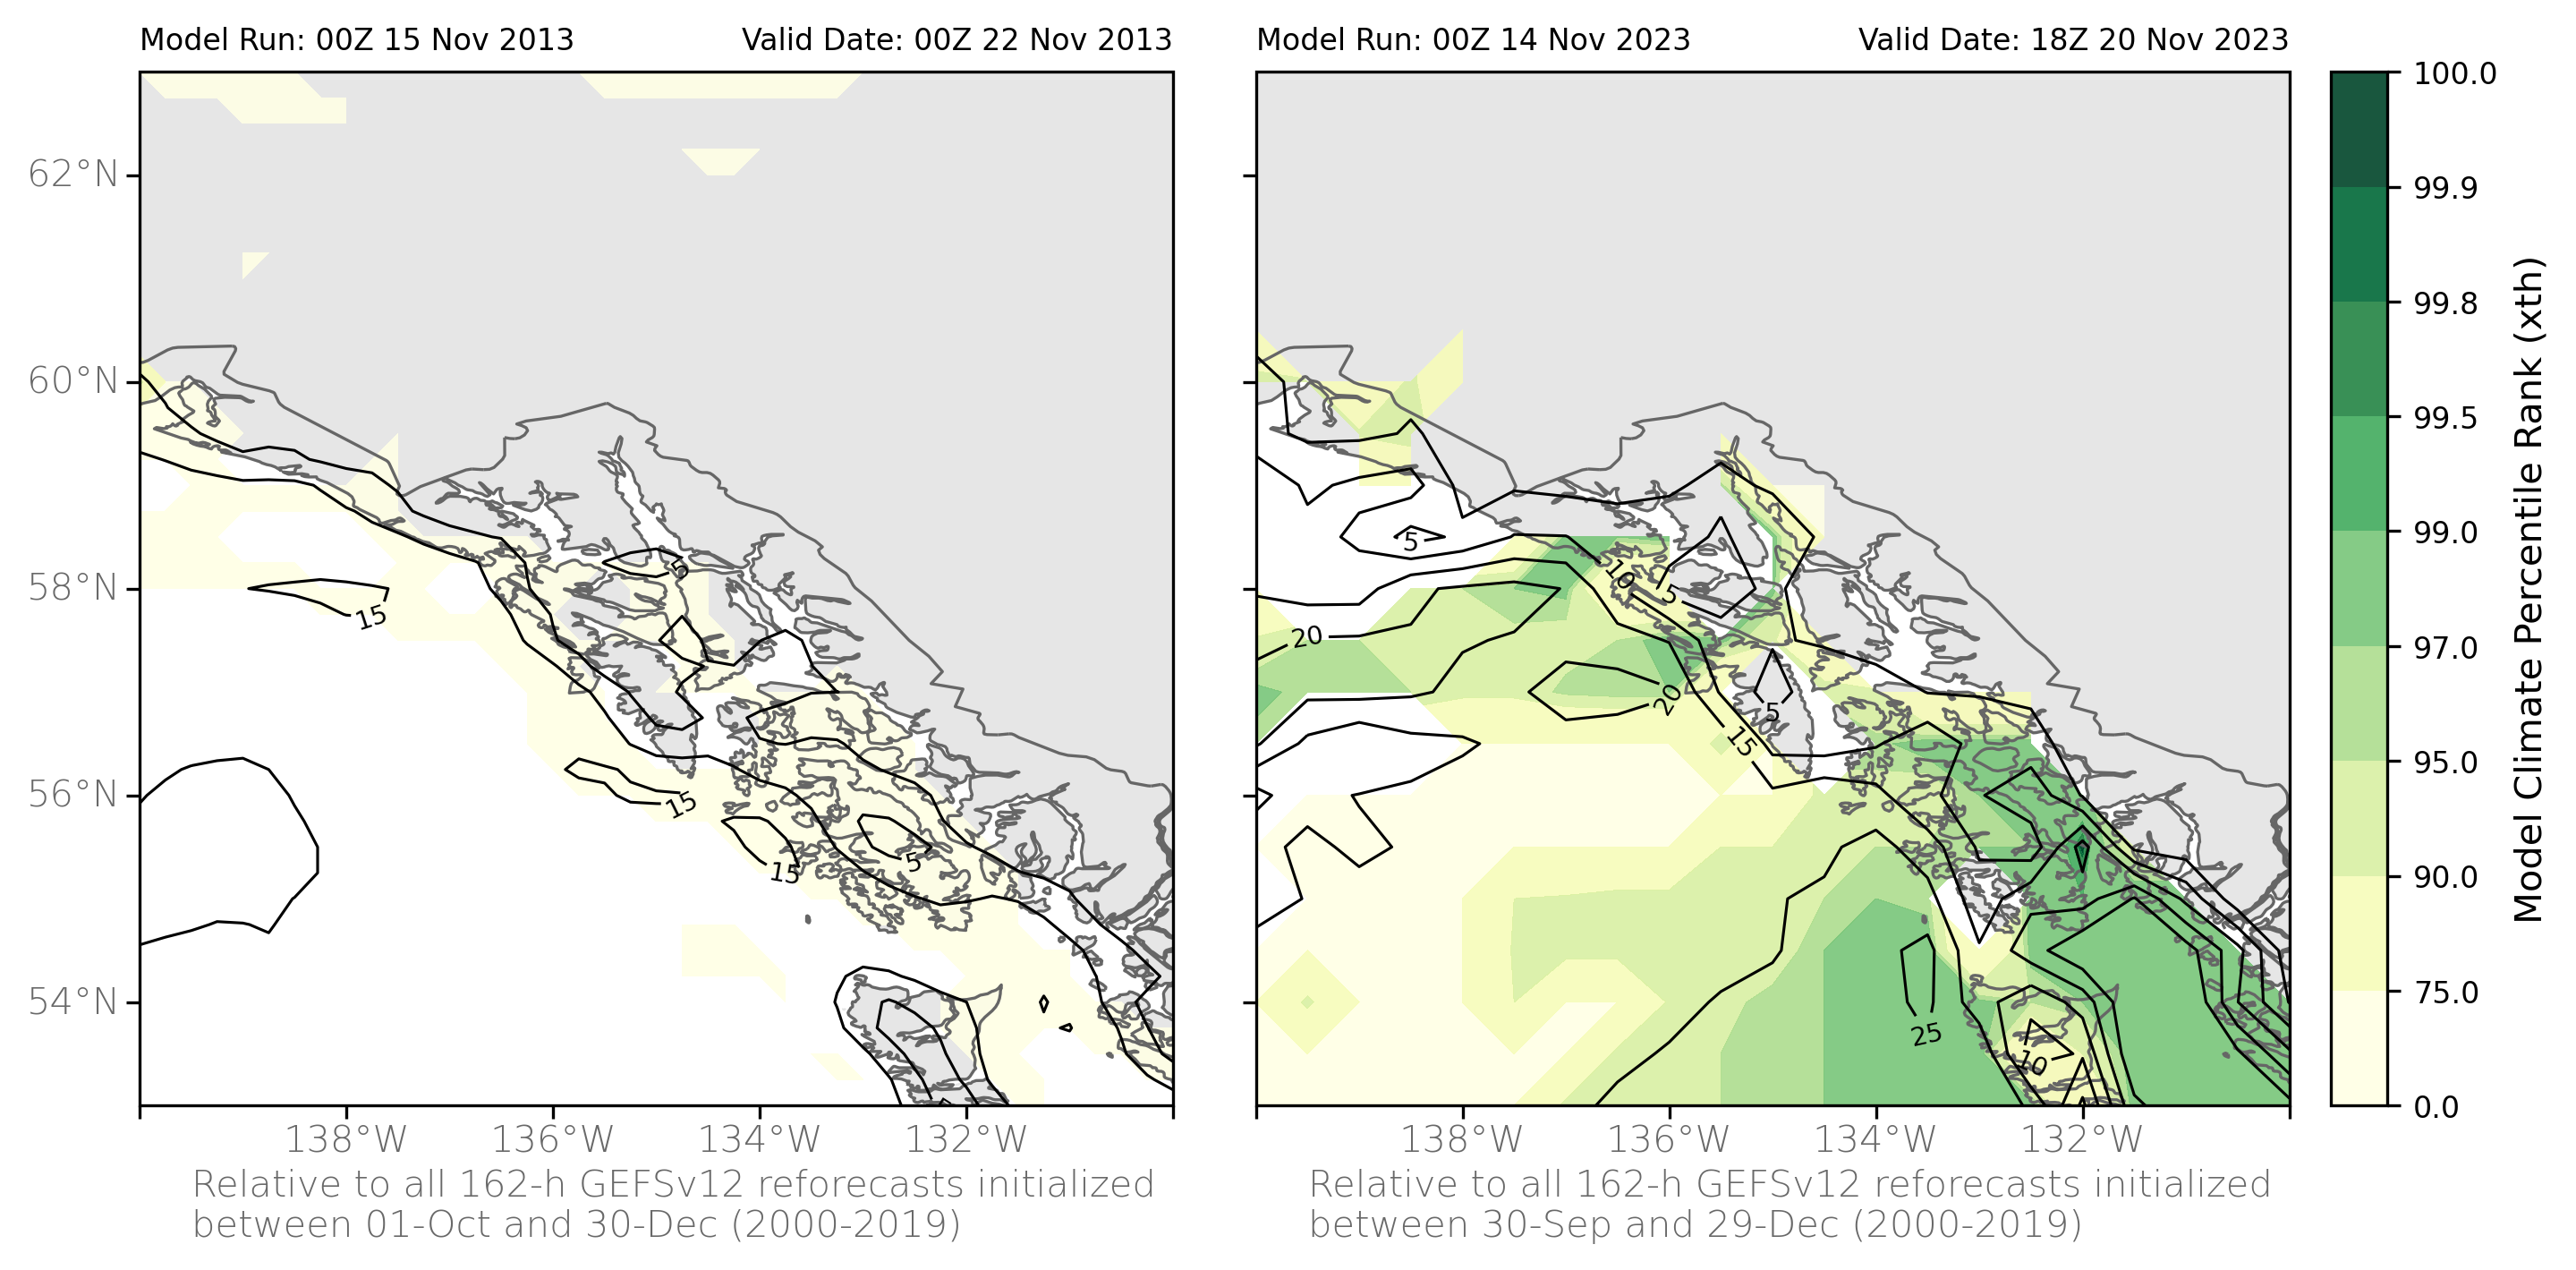

In [24]:
# Create figure
fig = plt.figure(figsize=(11, 5))
fig.dpi = 300
fname = path_to_figs + 'ams_poster_uv1000'
fmt = 'png'

nrows = 1
ncols = 3

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

kw_ticklabels = {'size': 10, 'color': 'dimgray', 'weight': 'light'}

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1, 1, 0.05], wspace=0.001, hspace=0.05)
## use gs[rows index, columns index] to access grids

###################
### CLIMATOLOGY ###
###################
leftlats_lst = [True, False]
for i, (fc, ds) in enumerate(zip(fc_lst, ds_lst)):
    ax = fig.add_subplot(gs[0, i], projection=mapcrs) 
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=leftlats_lst[i], right_lats=False, bottom_lons=True)
    
    # Contour Filled
    data = fc.mclimate.values*100.
    cmap, norm, bnds = ccmap.cmap('mclimate')
    cf = ax.contourf(fc.lon, fc.lat, data, transform=datacrs,
                     levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither')
    
    # Contour Lines
    clevs = np.arange(0., 30., 5.)
    cs = ax.contour(ds.lon, ds.lat, ds.uv, transform=datacrs,
                     levels=clevs, colors='k',
                     linewidths=0.75, linestyles='solid')
    plt.clabel(cs, **kw_clabels)
    
    ts = pd.to_datetime(str(ds.time.values)) 
    init_time = ts.strftime('%HZ %d %b %Y')
    start_date = ts - timedelta(days=45)
    start_date = start_date.strftime('%d-%b')
    end_date = ts + timedelta(days=45)
    end_date = end_date.strftime('%d-%b')
    
    ts = pd.to_datetime(str(ds.valid_time.values)) 
    valid_time = ts.strftime('%HZ %d %b %Y')
    
    ax.set_title('Model Run: {0}'.format(init_time), loc='left', fontsize=8)
    ax.set_title('Valid Date: {0}'.format(valid_time), loc='right', fontsize=8)

    
    txt = 'Relative to all 162-h GEFSv12 reforecasts initialized between {0} and {1} (2000-2019)'.format(start_date, end_date)
    ann_ax = fig.add_subplot(gs[-1, i])
    ann_ax.axis('off')
    ann_ax.annotate(textwrap.fill(txt, 60), # this is the text
               (0, 0.), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(25,-35), # distance from text to points (x,y)
                ha='left', # horizontal alignment can be left, right or center
                **kw_ticklabels)


# Add color bar
cbax = plt.subplot(gs[0,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('Model Climate Percentile Rank (xth)', fontsize=10)
cb.ax.tick_params(labelsize=8)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()